# CM 50270 Reinforcement Learning: Coursework 3 

**Total number of marks:** 100. (This coursework will determine 10% of your final grade for CM 50270.)

**What to submit:** Completed Jupyter notebook (`.ipynb` file) that includes all source code and runs in less than 3 minutes on a Bath lab PC. 

Alternatively, you can pre-compute some of the figures and include them using html tags in a markdown cell (see, for example, how we imported the tic-tac-toe figure in the following cell). If you use this approach, submit a .zip file (**not** `.rar`, `.7z`, or any other archive) that contains the completed Jupyter notebook (`.ipynb` file) as well as the pre-computed figures. Note that the notebook should still compute learning curves when run but with, for example, fewer agents.

Please do not change the notebook name in any case. Please ask in the Moodle forum if you have any questions about how to submit.

**Where to submit:** CM50270 Moodle page

This coursework will be __marked anonymously__. Please do not include any identifying information on the files you submit. 

You are required to __work individually__. You are welcome to discuss ideas with others but you must design your own implementation and write your own code.

__Do not plagiarise__. Plagiarism is a serious academic offence. For details on what it is and how to avoid it, please visit the following webpage: http://www.bath.ac.uk/library/help/infoguides/plagiarism.html

Restart the kernel and run all cells before submitting the notebook. This will guarantee that we will be able to run your code for testing.

Remember to save your work regularly. 

## Tic-Tac-Toe (100 marks)

In this exercise you will implement the game of [Tic-Tac-Toe](https://en.wikipedia.org/wiki/Tic-tac-toe) (also known as _noughts and crosses_) and learn an optimal policy using **Q-learning**. You will then implement **SARSA** and compare the two learning approaches with each other.

### The game

Tic-Tac-Toe is a paper-and-pencil game for two players, O and X, who take turns marking the spaces in a 3×3 grid. The player who succeeds in placing three of their marks in a horizontal, vertical, or diagonal row wins the game. The following example game is won by player X (example from [Wikipedia](https://en.wikipedia.org/wiki/Tic-tac-toe)):
<img src="images/tic-tac-toe_WIKI.png" style="width: 600px;"/> 

### Instructions
Implement the game of Tic-Tac-Toe. The first-moving player is randomly chosen at the beginning of each episode. Rewards of +1, −1, and 0 are given for winning, losing, and drawing, respectively. All rewards within a game are zero; do not discount ($\gamma = 1$). Player X will always be played by a _random agent_. This agent randomly chooses one of the empty grid spaces and marks it with "X". You will implement different agents for Player O.

We will ask you to plot your results and to discuss the produced plots. Please make sure to **label your figures appropriately**. Please only use plotting packages that come pre-installed with Anaconda 3. We recommend the package `matplotlib` (the tutorial provided in the first lab contains a whole section on matplotlib).

### a) Random policy against a random policy (10 marks)
Test your Tic-Tac-Toe implementation by letting two random agents play against each other. Plot the **cumulative rewards** of both O and X as a function of the number of episodes played. 

In [1]:
############################################################ RL CWK 3 ###########################################################

"""
This is the third reinforcement learning coursework to explore the differences between SARSA and Q Learning by playing noughts
and crosses (Known as tic tac toe outside the UK).

I have created 5 Classes:

NandC          - This is a class to effeciently implement noughts and crosses games such that thee agents can train on and test
                 on.

AgentPlay      - This is a wrapper for some functions such that any two agents can automatically play randomly aginst each
                 other.

Agent          - This is an abstract class defining the nesecarry functions and vaiables so that a child class can play within
                 the Agent play class.

RandomAgent    - This agent plays wholly randomly.

QLearningAgent - This is the implementation of a Q Learning agent, before playing the agent must be initialised and trained.

SARSAAgent     - This is the implementation of a SARSA agent, before playing the agent must be initialised and trained.
"""

############################################################ Imports ############################################################

from scipy.signal import savgol_filter
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# Changing default matplotlib font size

############################################################ Classes ############################################################

class NandC:
    """
    This is an implementation of noughts and crosses.  To improve effeciency the internal representation uses integers in a 1D
    array.  The internal representation is critical to understand as it guides the operation of everything.  I have tried to
    implement computationally fast methods as games must be run thousands of times to train the agentss, hence speed is of the
    essence.  This has lead to storing as much information as possibl in memory look up tables as opposed to repeatedly
    performing unesecarry calculations.

    Internal representation:
        0 = empty cell
        1 = O
        2 = X
    Game board cell numbers:
        ┌───┬───┬───┐
        │ 0 │ 1 │ 2 │
        ├───┼───┼───┤
        │ 3 │ 4 │ 5 │
        ├───┼───┼───┤
        │ 6 │ 7 │ 8 │
        └───┴───┴───┘
    Game board internal representation:
        [0,1,2,3,4,5,6,7,8]
    """

    def __init__(self):
        """
        Class constructor.  The current game board is self.board, this is flat array of length 9 as previously specified.  The
        board is only initialised once to improve effeciency.  Wins are determined by pattern matching with self.slices; by
        storing the indexes at which wins can be found the operation to determine a win is much simpler and more effecient.
        """
        self.board = np.zeros(9, dtype = int)
        # This is the board: 0 is empty; 1 is O; 2 is X.
        self.slices = [[0,1,2],[3,4,5],[6,7,8], # Horizontals
                       [0,3,6],[1,4,7],[2,5,8], # Verticals
                       [0,4,8],[6,4,2]]         # Diagonals
        # Initialising this once is much more effecient, this is an array of the positions to check for a victory.

    def reset(self):
        """
        This method is used to reset the game, it must be run before any game is played even after initialising the class fo the
        firsst time.  The first step fills the board, this is more eeffecient than creating a new array as memory is merely
        overwitten as opposed to allocated.  The players turn, self.playerTurn is reset randomly to either 1 or 2, meaning that
        either Os or Xs has an even chance of starting, this is critical as the starting play has a massive statistical chance
        of winning.

        Finally self.emptyCells is created, this is a list of the indexes in the board at which empty cells are; the variable is
        absolutely critical as it means that each agent does not have to determine itself where the empty cells are istead the
        game does this.  The reason that this is better is that the game knows every move what cell is taken out so does not
        need to search which one to remove, in contrast the agent does need to search,  consequently this represents massive
        effeciency savings.
        """
        self.board.fill(0)
        # Resets the map to empty again, this is marginally more effecient the reinitilising the map.
        self.playerTurn = np.random.randint(1,3)
        # Randomly resets which player starts using a uniform distribution.
        self.emptyCells = np.array([0,1,2,3,4,5,6,7,8], dtype = int)
        # This is a list of the cells which are empty.

    def hasWon(self, player):
        """
        This utalises the win look up table to determine whether a given player has won, it returns true if this is indeed the
        case.
        """
        win = False
        for i in self.slices:
            # Checks through all win slices
            if ((self.board[i[0]]==player) and (self.board[i[1]]==player) and (self.board[i[2]]==player)):
                # Conditional to check all numbers in a slice match the player number.
                win = True
                # If all conditions met then at the player has at least one win.
        return win

    def deleteEmptyCell(self, index):
        """
        Deletes an empty cell given an index, this is used to keep self.emptyCells updateted.
        """
        for i in range(np.shape(self.emptyCells)[0]):
            if self.emptyCells[i] == index:
                self.emptyCells = np.delete(self.emptyCells, i)
                return

    def play(self, index):
        """
        Places a mark on the board and checks if a player has won or not.  Returns both whether the player can play and who has
        won.  This is 0 for in progress; 1 for player 1 or noughts; 2 for player 2 or crosses; and 3 for a draw.
        """
        playerTurn = self.playerTurn
        if self.board[index] == 0:
            self.board[index] = self.playerTurn
            canPlay = True
            # If player can play places marker.
            if self.playerTurn == 1:
                self.playerTurn =2
            else:
                self.playerTurn = 1
            # Changes the players turn.
            self.deleteEmptyCell(index)
            # Deletes the index from epmty cells.
        else:
            canPlay = False
            # If player cannot play does not place marker and does not change the turn.
        hasWon = self.hasWon(playerTurn)
        # Checks if play has one after turn.
        if (hasWon == False) and (np.shape(self.emptyCells)[0] == 0):
            winner = 3
            # Sets winner to 3 if there is a draw.
        elif (hasWon == True):
            winner = playerTurn
            # Sets winner to the player.
        else:
            winner = 0
            # If game in progress winner = 0.
        return canPlay, winner

    def printBoard(self):
        """
        Used for visual diagnostics to print the grid in a nice pretty way with box drawing characters and so forth.
        """
        output = "┌───┬───┬───┐\n"
        output += "│"
        for j in range(3):
            if self.board[j] == 0:
                output += "   │"
            if self.board[j] == 1:
                output += " O │"
            if self.board[j] == 2:
                output += " X │"
        output += "\n├───┼───┼───┤\n│"
        for j in range(3):
            if self.board[j+3] == 0:
                output += "   │"
            if self.board[j+3] == 1:
                output += " O │"
            if self.board[j+3] == 2:
                output += " X │"
        output += "\n├───┼───┼───┤\n│"
        for j in range(3):
            if self.board[j+6] == 0:
                output += "   │"
            if self.board[j+6] == 1:
                output += " O │"
            if self.board[j+6] == 2:
                output += " X │"
        output += "\n└───┴───┴───┘\n"
        print(output)



class AgentPlay:
    """
    This is fundementally a wrapper to play games between two agents and determine the winner.  The class takes two agents,
    agentO who will play the O markers (This is who the two reinforcement learning agents play as) and agentX who plays the
    X markers.
    """
    def __init__(self, agentO, agentX):
        """
        Constructor.  the agents self.agentO and self.agentX are taken by reference so are the actual agents initialised outside
        the class.  A new game board is initialised for the class, self.NC.
        """
        self.NC = NandC()
        # New noughts and crosses object.
        self.NC.reset()
        # Resets the game for the first time.
        self.agentO = agentO
        self.agentX = agentX
        # the verious agents set by reference.

    def playGame(self, printGame = False):
        """
        plays a game between the two agents and returns the result of that game, 1 for player O winning, 2 for player X winning
        and 3 for a draw.  To reitirate X and O are randomly chosen as starting players, no one player should start more than
        the other over long periods.

        The function takes an argument printGame which allows a game to be printed, this is for diagnostics.
        """
        self.NC.reset()
        while True:
            if self.NC.playerTurn == 1:
                moveIndex = self.agentO.move(self.NC)
            else:
                moveIndex = self.agentX.move(self.NC)
            validMove, result = self.NC.play(moveIndex)
            if result != 0:
                # Game has ended.
                return result
            if printGame:
                self.NC.printBoard()
                # Option to print the game.

    def addReward(self, result):
        """
        This function takes the result of a game and calls the agents add reward function to add a reward to the agent.
        """
        if result == 1:
            self.agentO.addReward(1)
            self.agentX.addReward(-1)
        if result == 2:
            self.agentO.addReward(-1)
            self.agentX.addReward(1)
        if result == 3:
            self.agentO.addReward(0)
            self.agentX.addReward(0)

    def playGames(self, numberGames, addRewards = False):
        """
        This function plays a sepcified number of games, it has an option to addRewards, this means that if required the method
        will run the add rewards function after every game.
        """
        for i in range(numberGames):
            result = self.playGame()
            if addRewards == True:
                self.addReward(result)



class Agent:
    """
    Although python doesn't really have abstract classes, creating a class to inherit from is useful as it means that I have a
    reference point of what functions must be included.  This class represents a general agent with a move function which takes
    the gcurrent NandC object or game and decides what move to take next.
    """
    def __init__(self):
        """
        Class constructor.
        """
        self.cumulativeReward = 0
        # This is the agent's cumulative reward.
        self.cumulativeList = []
        # This is a list of the cumulative reward the agent has throughout its lifetime of games.

    def move(self, NC):
        """
        Method to determine the next move the agent will play given the NandC object.
        """
        return index # index is the position in the grid to play at.

    def addReward(self, reward):
        """
        Takes the reward and adds cumulatively to it.
        """
        self.cumulativeReward += reward
        self.cumulativeList.append(self.cumulativeReward)



class RandomAgent(Agent):
    """
    This implements the parent class, Agent, to create a random agent which randomly selects a move to take from the avalible
    moves.
    """
    def move(self, NC):
        """
        Returns a random but valid move.
        """
        index = np.random.randint(0,np.shape(NC.emptyCells)[0])
        # Decides on an index to choose from in the empty cells over the length of the empty cells.
        moveIndex = NC.emptyCells[index]
        # Decides on a move by outputting the index of the position in the board at which a marke should be put.
        return moveIndex

######################################################## Demonstrating #########################################################

np.random.seed(42)
# Seeding the numpy random class to ensure consistent results each time the cell is run.

ranAgentO = RandomAgent()
# Creates a random agent for the O player.
ranAgentX = RandomAgent()
# Creates a random agent for the X player.
agentPlay = AgentPlay(ranAgentO, ranAgentX)
# Initialises an agent game environment to pit the two agents against each other.
agentPlay.playGames(1000,True)
# The agents play 1000 games, whilst adding to their cumulative reqards.

matplotlib.rcParams.update({'font.size': 15})
fig, ax = plt.subplots(figsize=(10, 10))
line1, = ax.plot(ranAgentX.cumulativeList, label='Cumulative Reward for random agent playing as X',
                 linestyle = '-', color = 'k')
line2, = ax.plot(ranAgentO.cumulativeList, label='Cumulative Reward for random agent playing as X',
                 linestyle = '--', color = 'k')
line3, = ax.plot(range(1000), label='Expected Cumulative Reward for Perfect Player',
                 linestyle = ':', color = 'k')
ax.set_xlabel('Number of Games')
ax.set_ylabel('Cumulative Reward')
ax.set_title("Plot of the Cumulative Reward of\nTwo Random Agents vs a 'Perfect Player' Over 1000 Games\n")
ax.legend()
# Creating the plot of cumulative rewards.

#################################################################################################################################

In a few sentences, discuss your results. Did you expect these results? Why or why not? (We will mark only the first three sentences. Please do not write any longer than that.) 



In [2]:
"""
Given that agents randomly start first, and that they always make random moves, I would expect that neither would gain a
statistical advantage; this is what can be observed in the graph.  Although the agents occasionally perform better over short
periods of time, this is expected through random varience and over long periods this can be seen to cancel out.  I have included
what the score would be for a perfect player to contrast how poorly the random agents perform, this is an important visual cue
otherwise it is easy to mistake random variation as good performence.

Note to marker, matplotlib occasionally has a tantrum and won't display the graph the first time the cell is run, to solve
simply run cell above again.
"""

"\nGiven that agents randomly start first, and that they always make random moves, I would expect that neither would gain a\nstatistical advantage; this is what can be observed in the graph.  Although the agents occasionally perform better over short\nperiods of time, this is expected through random varience and over long periods this can be seen to cancel out.  I have included\nwhat the score would be for a perfect player to contrast how poorly the random agents perform, this is an important visual cue\notherwise it is easy to mistake random variation as good performence.\n\nNote to marker, matplotlib occasionally has a tantrum and won't display the graph the first time the cell is run, to solve\nsimply run cell above again.\n"

### b) Q-learning (30 marks)
Use Q-learning to learn an optimal policy for playing Tic-Tac-Toe against a random opponent. Produce a learning curve for your agent. That is, (1) plot **average return** as a function of episodes, (2) the learning curve should plot the average return of many agents (please specify how many agents you are averaging). 

For your reference, the pseudo-code for Q-learning is reproduced below from the textbook (Reinforcement Learning, Sutton & Barto, 1998, Section 6.5).
<img src="images/q_learning.png" style="width: 600px;"/>
 

Text(0.5,1,'Q Learning Agent Learning Curve\n')

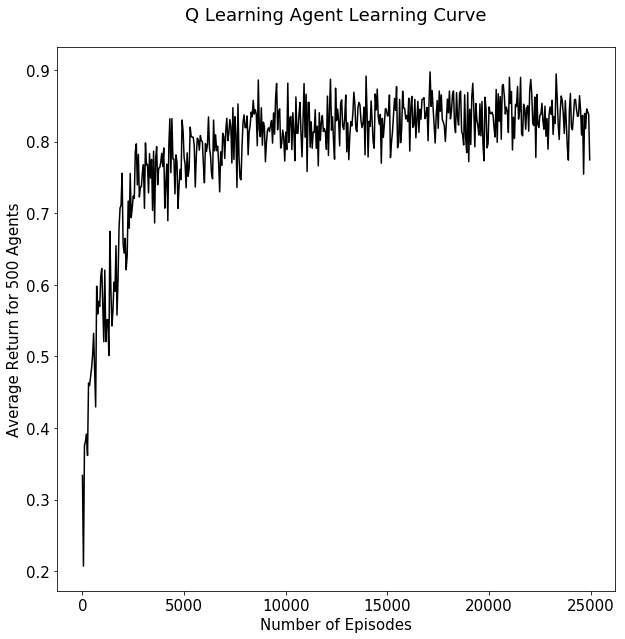

In [2]:
############################################################ Classes ############################################################

class QLearningAgent(Agent):
    """
    This class implements a q learning agent for tic tac toe.  An important feature to note is that the opposing agent is
    simply considered part of the environment.
    """
    def __init__(self, epsilon, alpha):
        """
        Constructor, overwriting original method to allow for Q states to be added alongside a testing and training environment.
        """
        self.cumulativeReward = 0
        self.cumulativeList = []
        # this stores the cumulative rewards of the agent during a game play.

        self.epsilon = epsilon
        # Epsilon for the epsilon greedy policy, this is the exploration rate, basically how often the chosen action will not
        # be taken during learning, this is such that the agent visists a large number of states.
        self.alpha = alpha
        # Alpha is the learning rate, essentially the size of step between the action tate values, the larger alpha is the
        # quicker convergence, however the values become grainy so are a less acurate representation of the true values.

        self.Q = np.zeros((19683,9))
        # This is the total number of potential states, in reality only about 6000 are actually filled as many states can never
        # actually be accesed during a noughts and crosses game.

        # This sets up the training environment for the agent to train in.
        self.trainNC = NandC()
        # This is the map to train on.
        self.trainPartner = RandomAgent()
        # This is the random partner to train against.
        self.trainPlay = AgentPlay(self, self.trainPartner)
        # Thid sets up the environment to train in.

        # This sets up the testing environment, this allows th agent to test its' own performence after each epsiode.
        self.testNC = NandC()
        # This is the map to test on.
        self.testPartner = RandomAgent()
        # This is the random partner to test against.
        self.testPlay = AgentPlay(self, self.trainPartner)
        # Thid sets up the environment to test in.

    def getIndex(self, state):
        """
        The boards are represented by an array of length nine with elements being either a 1, 2 or 3.  Consequently there
        are 3^9 possible ways of arranging X's or O's on a board.  Obviously some of these states can never be reached, but
        regardless this is a convinient way to index state action values, as for a given state there should be a set of
        given actions no larger than 9, one for each empty tile.  Consequently I create an array of length 3^9 or 19683 with
        depth nine, this has the required space to contain everything!
        
        This also provides a usefull indexing method as in reality the state is a ternary number of length 9, hence given this
        state there should be a one to one mapping to the Q array.  This is done using a function that essentially converts from
        ternary to decimal very quickly.
        """
        state = np.flip(np.copy(state), axis=0)
        # Reverses the array.
        multipliers = np.array([1,3,9,27,81,243,729,2187,6561])
        # Exponents of three to myultiply by.
        index = np.sum(state*multipliers)
        return index

    def updateEpisode(self):
        """
        Perfroms a state update episiode based on the q learning algorithm.
        
        Initialize Q(s, a), for all s ∈ S, a ∈ A(s), arbitrarily, and Q(terminal-state, ·) = 0
        Repeat (for each episode):
            Initialize S
            Repeat (for each step of episode):
                Choose A from S using policy derived from Q (e.g., epsilon-greedy)
                Take action A, observe R, S'
                Q(S, A) ← Q(S, A) + α[R + γ maxa Q(S', a) − Q(S, A)]
                S ← S'
            until S is terminal
            
        Q Learning Algorithm from Reinforcment Learning: An Introduction by Richard S. Sutton and Andrew G. Barto.
        
        The Agent itself is always considered as player 1 or O, this is okay as the episodes are randomly over both O starts and
        X starts, consequently when learning it will visit states from wher it does and doesn't start.
        
        The opposing agent is considered as part of the environment, this is a useful simplification.
        """

        ################################################### EPSISODE STARTED ####################################################

        self.trainNC.reset()
        # Resets the map.
        # ALGORITHM: Initialize S

        if self.trainNC.playerTurn == 2:
            trainA = self.trainPartner.move(self.trainNC)
            self.trainNC.play(trainA)
            # Lets the training partner play if the start is for player 2, updating the environment.

        gameEnded = False
        # Condition to check whether an game or episode has ended.

        while gameEnded == False:
            # This plays through an entire game.
            # ALGORITHM: Repeat (for each step of episode):

            ################################################### AGENTS TURN #####################################################
            Acur = self.epsilonGreedyMove(self.trainNC, self.epsilon)
            # Choses an action epsilon greedily based on it's current policy.
            # ALGORITHM: Choose A from S using policy derived from Q (e.g., epsilon-greedy)
            Scur = np.copy(self.trainNC.board)
            # Sets S as the current board, equvilent to the state.
            QScurAcur = np.copy(self.Q[self.getIndex(Scur),Acur])
            # Sets QSA to the current state action value for the chosen action.

            validMove, result = self.trainNC.play(Acur)
            # The agent makes the given move by taking the action it decided on.
            # ALGORITHM: Take action A,
            ################################################ END OF AGENTS TURN #################################################

            ################################################ ENVIRONMENT REACTS #################################################
            # The following step terminates the episode if the agent has won the game. Consequently the next state action value
            # will be zero as it does not exist, and the reward is either a win or a draw as an agent cannot loose immediately
            # after it's move.
            if (result == 1):
                R = 1
                # ALGORITHM: observe R
                QSprimeAmax = 0.0
                gameEnded = True
                # Agents action won the game.
                # ALGORITHM: until S is terminal
            elif (result == 3):
                R = 0
                # ALGORITHM: observe R
                QSprimeAmax = 0.0
                gameEnded = True
                # Agents action drew the game.
                # ALGORITHM: until S is terminal

            # This sequence occurs if the agent's move did not end the game, allowing the training agent to make a move. Another
            # step in the environment reacting.
            elif (result == 0):
                partnerA = self.trainPartner.move(self.trainNC)
                # The training agent randomly decides on a move to make.
                validMove, result = self.trainNC.play(partnerA)
                # The training agent makes the move updating the environment.
                Sprime = np.copy(self.trainNC.board)
                # After the agent has taken it's action the next state can now be observed.
                # ALGORITHM: observe S'

                # The following step determins if the training agent's move has lost the game for the agent.
                if (result == 2):
                    R = -1
                    # ALGORITHM: observe R
                    QSprimeAmax = 0.0
                    gameEnded = True
                    # Training partners move lost the game.
                    # ALGORITHM: until S is terminal
                elif (result == 3):
                    R = 0
                    # ALGORITHM: observe R
                    QSprimeAmax = 0.0
                    gameEnded = True
                    # Training partners move drew the game.
                    # ALGORITHM: until S is terminal

                # Finally if the agent's move nor the training partners move ended the game the following takes place.
                else:
                    R = 0
                    # ALGORITHM: observe R
                    Aprime = self.move(self.trainNC)
                    # Works out what gredily what the best action is.
                    QSprimeAmax = np.copy(self.Q[self.getIndex(Sprime),Aprime])
                    # This observes the maximum action state value is by working choosing an action greedily, this basically
                    # co-opting already built code.
                    # ALGORITHM: maxa Q(S', a)
            ##################################### ENVIRONMENT HAS REACTED, R, S' OBSERVED #######################################

            ################################################## AGENT UPDATES ####################################################

            self.Q[self.getIndex(Scur),Acur] = QScurAcur + self.alpha*(R+QSprimeAmax-QScurAcur)
            # This is the business end of the algorithm and actually updates the state action values.
            # ALGORITHM: Q(S, A) ← Q(S, A) + α[R + γ maxa Q(S', a) − Q(S, A)]

            # Finally ALGORITHM: S ← S' does not need to be explicitly done as the testing environment is updated as it goes
            # along.

            ################################################## UPDATE COMPLETE ##################################################

        ################################################ TERMINAL STATE REACHED #################################################

    def epsilonGreedyMove(self, NC, epsilon):
        """
        Works out what move to take given the NandC object according to an epsilon greedy policy.  This means that the move
        taken has a precisely defined chance f being completely random.
        """
        actions = NC.emptyCells
        # These are the availible actions.
        Qs = self.Q[self.getIndex(NC.board)]
        # Gets the Q values for the board
        Qs = np.take(Qs, actions)
        # Gets only the q values which have an action.
        maxQ = np.argmax(Qs)
        # Gets the index of the max q value.
        optimalAction = actions[maxQ]
        # Gets the index of of the maximum value and uses this to find the optimal action.
        randomNum = np.random.random()
        # Creates a uniformly random float between 1 and 0.
        if randomNum < 1-epsilon:
            return optimalAction
            # Returns the index of the best action with respect to the policy with probability 1-epsilon.
        else:
            optimalAction = actions[np.random.randint(0,len(actions))]
            return optimalAction
            # Returns a random action with probability epsilon/numactions.

    def move(self, NC):
        """
        This performs a greedy move based on the agents policy, this is how the agent acts when not training.
        """
        actions = NC.emptyCells
        # These are the availible actions.
        Qs = self.Q[self.getIndex(NC.board)]
        # Gets the Q values for the board
        Qs = np.take(Qs, actions)
        # Gets only the q values which have an action.
        maxQ = np.argmax(Qs)
        # Gets the index of the max q value.
        optimalAction = actions[maxQ]
        # Gets the index of of the maximum value and uses this to find the optimal action.
        return optimalAction

    def train(self, episodes, testInterval, testAgents):
        """
        The method trains the agent, and creates a learning curve at the same time.
        """
        learningCurve = []
        # This is a list of measured rewards at given steps in the training.
        testEpisodes = []
        # This a list of the episode at which each test was perfomed.
        for i in range(episodes):
            self.updateEpisode()
            # Performs an update episode.
            if i % testInterval == 0:
                # If at a testing interval performs a test.
                self.cumulativeList = []
                self.cumulativeReward = 0
                # Resets it's own rewards lists.
                self.testPlay.agentO = self
                # Ensures the testing environment has the most up to date version of itself.
                self.testPlay.playGames(testAgents,True)
                # Plays a specified number of games
                avgReward = np.mean(np.array(self.cumulativeList)/np.array(range(1,testAgents+1)))
                # Works out the average reward of the tests.
                learningCurve.append(avgReward)
                # Adds the reward to the list.
                testEpisodes.append(i)
        return learningCurve, testEpisodes

######################################################## Demonstrating #########################################################

np.random.seed(42)
# Seeding the numpy random class to ensure consistent results each time the cell is run.

qAgent = QLearningAgent(epsilon = 0.2, alpha = 0.01)
# Initialising the Q learning agent.
QlearningCurve, QtestEpisodes = qAgent.train(25000,50,500)
# Training the agent.

matplotlib.rcParams.update({'font.size': 15})
fig, ax = plt.subplots(figsize=(10, 10))
line1, = ax.plot(QtestEpisodes, QlearningCurve, label='Q Learning Agent',
                 linestyle = '-', color = 'k')
ax.set_xlabel('Number of Episodes')
ax.set_ylabel('Average Return for 500 Agents')
ax.set_title("Q Learning Agent Learning Curve\n")
# Creating the plot of cumulative rewards.

#################################################################################################################################

In 3 sentences or less, (1) explain the state representation you used, (2) discuss the learning curve you produced. 


In [4]:
"""
Each state or board layout is represented as a flat 1D array of length 9, with the idexes going from left to right then down;
each element in the array is then either 0 for empty, 1 for an X or 2 for a O.  The learning curve is what I expect, with a
slowing rate of convergence to a maximum average win rate of about 0.85; this about the highest attainable win rate, as half of
the time the opponent starts first, which has a massive statistical advantage to winning, given a perfect player can always
roce a win or a draw from starting first.  Although the curve has lots of noise, this is also to be expected given the
stoichastic nature o gameplay against a random opponent; I could have reduced this by averageing more agents, but this quickly
becomes computationally slow.

Note to marker, curve takes approximately 45s to produce on a uni computer.
"""

'\nEach state or board layout is represented as a flat 1D array of length 9, with the idexes going from left to right then down;\neach element in the array is then either 0 for empty, 1 for an X or 2 for a O.  The learning curve is what I expect, with a\nslowing rate of convergence to a maximum average win rate of about 0.85; this about the highest attainable win rate, as half of\nthe time the opponent starts first, which has a massive statistical advantage to winning, given a perfect player can always\nroce a win or a draw from starting first.  Although the curve has lots of noise, this is also to be expected given the\nstoichastic nature o gameplay against a random opponent; I could have reduced this by averageing more agents, but this quickly\nbecomes computationally slow.\n\nNote to marker, curve takes approximately 45s to produce on a uni computer.\n'

### c) Optimal policy (20 marks)
What is the optimal play for the agent in the following state? 
<img src="images/tic_tac_toe.png" style="width: 80px;"/> 
You must answer by writing a function that takes a state as input and _prints_ the "after-state" that would result from playing an optimal action. The printed output can be primitive but the board has to be somewhat recognizable.   

In [5]:
np.random.seed(42)
# Seeding the numpy random class to ensure consistent results each time the cell is run.

testNC = NandC()
# Initialises the noughts and crosses environment
testNC.reset()
# Resets the board.
testNC.board = [1,2,0,0,2,0,0,1,0]
# Sets the board to what is shown.
testNC.emptyCells = [2,3,5,6,8]
# Sets the empty cells to what is shown.
action = qAgent.move(testNC)
# Feeds the qAgent the board so it can determine the move to make.
testNC.play(action)
# Taking the action on the board.
testNC.printBoard()
# Printing the new state of the board.

# Note to marker - I use box drawing symbols, on certain systems they do not display correctly, however if using jupyter with a 
# modern browser this should not be an issue.

┌───┬───┬───┐
│ O │ X │ O │
├───┼───┼───┤
│   │ X │   │
├───┼───┼───┤
│   │ O │   │
└───┴───┴───┘



Please ignore this cell. We will use this cell to mark your answer. 


### d) Sarsa (40 marks)
Implement Sarsa to learn how to play Tic-tac-toe against a random player. Produce a learning curve. Also include the learning curve of your previously trained Q-learning agent in the same plot. Discuss the learning curves. For your reference, the pseudo-code for SARSA is reproduced below from the textbook (Reinforcement Learning, Sutton & Barto, 1998, Section 6.4).
<img src="images/SARSA.png" style="width: 600px;"/>



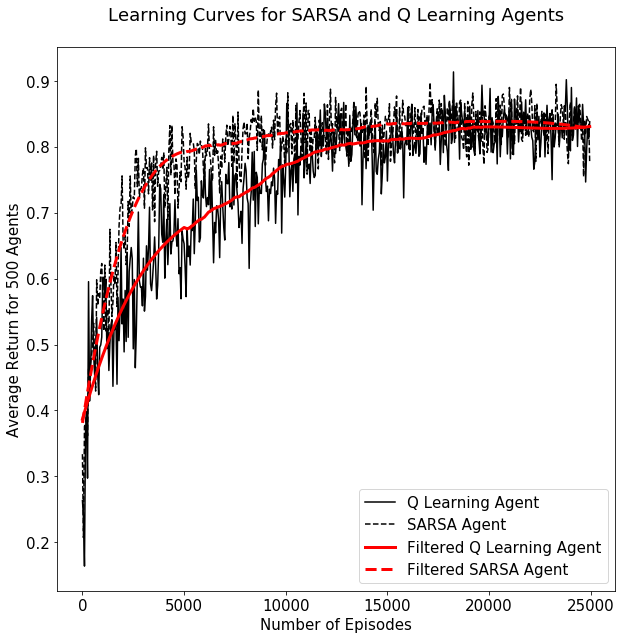

In [6]:
############################################################ Classes ############################################################

class SARSAAgent(QLearningAgent):
    """
    Implementation of both the Agent and QLearningAgent, in reality all of the methods between SARSA and QLearning are
    identical, aside from the update function, which is overridden such that it learns on policy.
    """
    def updateEpisode(self):
        """
        Perfroms a state update episiode based on the SARSA learning algorithm.
        
        Initialize Q(s, a), for all s ∈ S, a ∈ A(s), arbitrarily, and Q(terminal-state, ·) = 0
        Repeat (for each episode):
            Initialize S
            Choose A from S using policy derived from Q (e.g., epsilon-greedy)
            Repeat (for each step of episode):
                Take action A, observe R, S'
                Choose A' from S' using policy derived from Q (e.g., epsilon-greedy)
                Q(S, A) ← Q(S, A) + α[R + γ maxa Q(S', A') − Q(S, A)]
                S ← S'; A ← A';
            until S is terminal
            
        SARSA Learning Algorithm from Reinforcment Learning: An Introduction by Richard S. Sutton and Andrew G. Barto.
        """

        ################################################### EPSISODE STARTED ####################################################

        self.trainNC.reset()
        # Resets the map.
        # ALGORITHM: Initialize S
        
        if self.trainNC.playerTurn == 2:
            partnerA = self.trainPartner.move(self.trainNC)
            self.trainNC.play(partnerA)
            # Lets the training partner play if the start is for player 2.

        gameEnded = False
        # Condition to check whether an game or episode has ended.

        Acur = self.epsilonGreedyMove(self.trainNC, self.epsilon)
        # Chooses the initial action to take based in the agents policy in an epsilon greedy manner.
        Scur = np.copy(self.trainNC.board)
        # Sets the initial state.
        QScurAcur = np.copy(self.Q[self.getIndex(Scur),Acur])
        # Finds the initial state action value.
        # ALGORITHM: Choose A from S using policy derived from Q (e.g., epsilon-greedy)

        while gameEnded == False:
            # This plays through an entire game.
            # ALGORITHM: Repeat (for each step of episode):

            ################################################### AGENTS TURN ##################################################### 

            validMove, result = self.trainNC.play(Acur)
            # The agent takes an action based on the current action.
            # ALGORITHM: Take action A,
            
            ################################################ END OF AGENTS TURN #################################################

            ################################################ ENVIRONMENT REACTS #################################################
            # The following step terminates the episode if the agent has won the game. Consequently the next state action value
            # will be zero as it does not exist, and the reward is either a win or a draw as an agent cannot loose immediately
            # after it's move.
            if (result == 1):
                R = 1
                # ALGORITHM: observe R
                QSprimeAprime = 0.0
                gameEnded = True
                # Agents action won the game.
                # ALGORITHM: until S is terminal
            elif (result == 3):
                R = 0
                # ALGORITHM: observe R
                QSprimeAprime = 0.0
                gameEnded = True
                # Agents action drew the game.
                # ALGORITHM: until S is terminal

            # This sequence occurs if the agent's move did not end the game, allowing the training agent to make a move. Another
            # step in the environment reacting.
            elif (result == 0):
                # Agents action continued the game.
                partnerA = self.trainPartner.move(self.trainNC)
                # The training agent randomly decides on a move to make.
                validMove, result = self.trainNC.play(partnerA)
                # The training agent makes the move updating the environment.
                Sprime = np.copy(self.trainNC.board)
                # After the agent has taken it's action the next state can now be observed.
                # ALGORITHM: observe S'

                # The following step determins if the training agent's move has lost the game for the agent.
                if (result == 2):
                    R = -1
                    # ALGORITHM: observe R
                    QSprimeAprime = 0.0
                    gameEnded = True
                    # Training partners move lost the game.
                    # ALGORITHM: until S is terminal
                elif (result == 3):
                    R = 0
                    # ALGORITHM: observe R
                    QSprimeAprime = 0.0
                    gameEnded = True
                    # Training partners move drew the game.
                    # ALGORITHM: until S is terminal

                # Finally if the agent's move nor the training partners move ended the game the following takes place.
                else:
                    R = 0
                    Aprime = self.epsilonGreedyMove(self.trainNC, self.epsilon)
                    # Action for the new state is chosen epsilon greedily, this is the key difference between Q learning and
                    # SARSA.
                    QSprimeAprime = np.copy(self.Q[self.getIndex(Sprime),Aprime])
                    # Finds out what the state action value is for this action.
                    # ALGORITHM: Choose A' from S' using policy derived from Q (e.g., epsilon-greedy)

            ##################################### ENVIRONMENT HAS REACTED, R, S' OBSERVED #######################################

            ################################################## AGENT UPDATES ####################################################
            
            self.Q[self.getIndex(Scur),Acur] = QScurAcur + self.alpha*(R+QSprimeAprime-QScurAcur)
            # Updates the current state action value.
            # ALGROITHM: Q(S, A) ← Q(S, A) + α[R + γ maxa Q(S', A') − Q(S, A)]

            if result == 0:
                Acur = Aprime
                Scur = Sprime
                QScurAcur = np.copy(QSprimeAprime)
            # If the episode has not ended then the next steps current values are set to this steps prime values.
            # ALGORITHM: S ← S'; A ← A';

            ################################################## UPDATE COMPLETE ##################################################

        ################################################ TERMINAL STATE REACHED #################################################



######################################################## Demonstrating #########################################################

np.random.seed(84)
# Seeding the numpy random class to ensure consistent results each time the cell is run.

sarsaAgent = SARSAAgent(epsilon = 0.2, alpha = 0.01)
# Initialising the Q learning agent.
SARSAlearningCurve, SARSAtestEpisodes = sarsaAgent.train(25000,50,500)
# Training the agent.

SARSAlearningCurveSmoothed = savgol_filter(SARSAlearningCurve,201,3)
QlearningCurveSmoothed = savgol_filter(QlearningCurve,201,3)
# Creating smoothed curves which filter out the statistical noise.

matplotlib.rcParams.update({'font.size': 15})
fig, ax = plt.subplots(figsize=(10, 10))
line1, = ax.plot(SARSAtestEpisodes, SARSAlearningCurve, label='Q Learning Agent',
                 linestyle = '-', color = 'k')
line2, = ax.plot(QtestEpisodes, QlearningCurve, label='SARSA Agent',
                 linestyle = '--', color = 'k')
line3, = ax.plot(SARSAtestEpisodes, SARSAlearningCurveSmoothed, label='Filtered Q Learning Agent',
                 linestyle = '-', color = 'r', linewidth = 3)
line4, = ax.plot(QtestEpisodes, QlearningCurveSmoothed, label='Filtered SARSA Agent',
                 linestyle = '--', color = 'r', linewidth = 3)
ax.set_xlabel('Number of Episodes')
ax.set_ylabel('Average Return for 500 Agents')
ax.set_title("Learning Curves for SARSA and Q Learning Agents\n")
ax.legend()
# Creating the plot of cumulative rewards.

#################################################################################################################################

Discuss the learning curves in this cell in 5 sentences or less.


In [7]:
"""
Because the curves are based on actual averaged return of a 500 agents playing games every 50 episodes, rather than the return
generated whilst training, the agents both converge to aproximately the same maximum performance.  This is because unlike a
cliff world scenario, there is no inherent advantage in noughts and crosses of learning a cautious approach, consequently both
should converge to the same policy.  Again this maximum win rate of about 0.85 is dictated by the fact that there the opposing
random player can somtimes go first, and given that the first player can force a draw or win, even a random agent can somtimes
play perfectly causing a loss for the learning agents.  Alhough converging to the same point SARSA does so significantly faster,
the reason for this is that SARSA unlike Q Learning follows it's own policy.  Beacause SARSA follows it's own epsilon greedy
policy it randomly chooses actions more regularly, leading to it exploring more states over fewer episodes, this means that
SARSA generates Q-values more quickly intially, and updates them more regularly.

Note to marker - In order to resonably compare the two earning curves, I have used a Savitzky-Golay filter, to create two more
curves super-imposed ontop of the originals.  Otherwise noise drowns out any meanigfull differences between the curves. Again
the curve also takes about 45s o generate on a uni PC.
"""

"\nBecause the curves are based on actual averaged return of a 500 agents playing games every 50 episodes, rather than the return\ngenerated whilst training, the agents both converge to aproximately the same maximum performance.  This is because unlike a\ncliff world scenario, there is no inherent advantage in noughts and crosses of learning a cautious approach, consequently both\nshould converge to the same policy.  Again this maximum win rate of about 0.85 is dictated by the fact that there the opposing\nrandom player can somtimes go first, and given that the first player can force a draw or win, even a random agent can somtimes\nplay perfectly causing a loss for the learning agents.  Alhough converging to the same point SARSA does so significantly faster,\nthe reason for this is that SARSA unlike Q Learning follows it's own policy.  Beacause SARSA follows it's own epsilon greedy\npolicy it randomly chooses actions more regularly, leading to it exploring more states over fewer episod